# Cancer image classifiction task

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### Because the CUDA version is too high only the CPU version of TENSOR can be used. 

In [3]:
!pip install tensorboard

# Loading packets

In [4]:
import numpy as np
import matplotlib.pylab as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.utils import shuffle

import tensorflow
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import MaxPooling2D
import itertools
#This is a command that is typically used in a Jupyter notebook 
#to display plots created by the matplotlib library inline within the notebook, rather than in a separate window.
%matplotlib inline

## loading Dataset

In [5]:
X = np.load('data/X.npy') # Loading image data
Y = np.load('data/Y.npy') # Loading label data (0 = 非IDC, 1 = IDC)

This case experiment dataset consists of 5547 50 x 50 pixel RGB digital images of hematoxylin-eosin stained (H&E stained) histopathology samples of the breast, which are labeled as:
IDC (Flag: 1) Malignant tumour
Non-IDC ( Flag: 0) Benign tumour

## Disrupting the Dataset

In [6]:
# Data disruption
X,Y = shuffle(X,Y)
X,Y

(array([[[[194, 147, 186],
          [164, 123, 166],
          [214, 183, 206],
          ...,
          [208, 196, 214],
          [189, 161, 196],
          [209, 180, 201]],
 
         [[202, 152, 185],
          [194, 131, 171],
          [181, 112, 157],
          ...,
          [234, 224, 233],
          [199, 176, 197],
          [165, 142, 182]],
 
         [[215, 181, 205],
          [196, 131, 174],
          [195, 133, 174],
          ...,
          [217, 206, 220],
          [174, 151, 188],
          [ 71,  40,  96]],
 
         ...,
 
         [[178, 114, 157],
          [171, 107, 151],
          [201, 141, 177],
          ...,
          [201, 145, 185],
          [187, 122, 169],
          [187,  99, 143]],
 
         [[180, 107, 152],
          [200, 119, 164],
          [171, 103, 151],
          ...,
          [190, 125, 162],
          [156, 115, 158],
          [176, 109, 154]],
 
         [[194, 151, 186],
          [183, 121, 165],
          [183, 121, 160],
   

# Data set visualisation

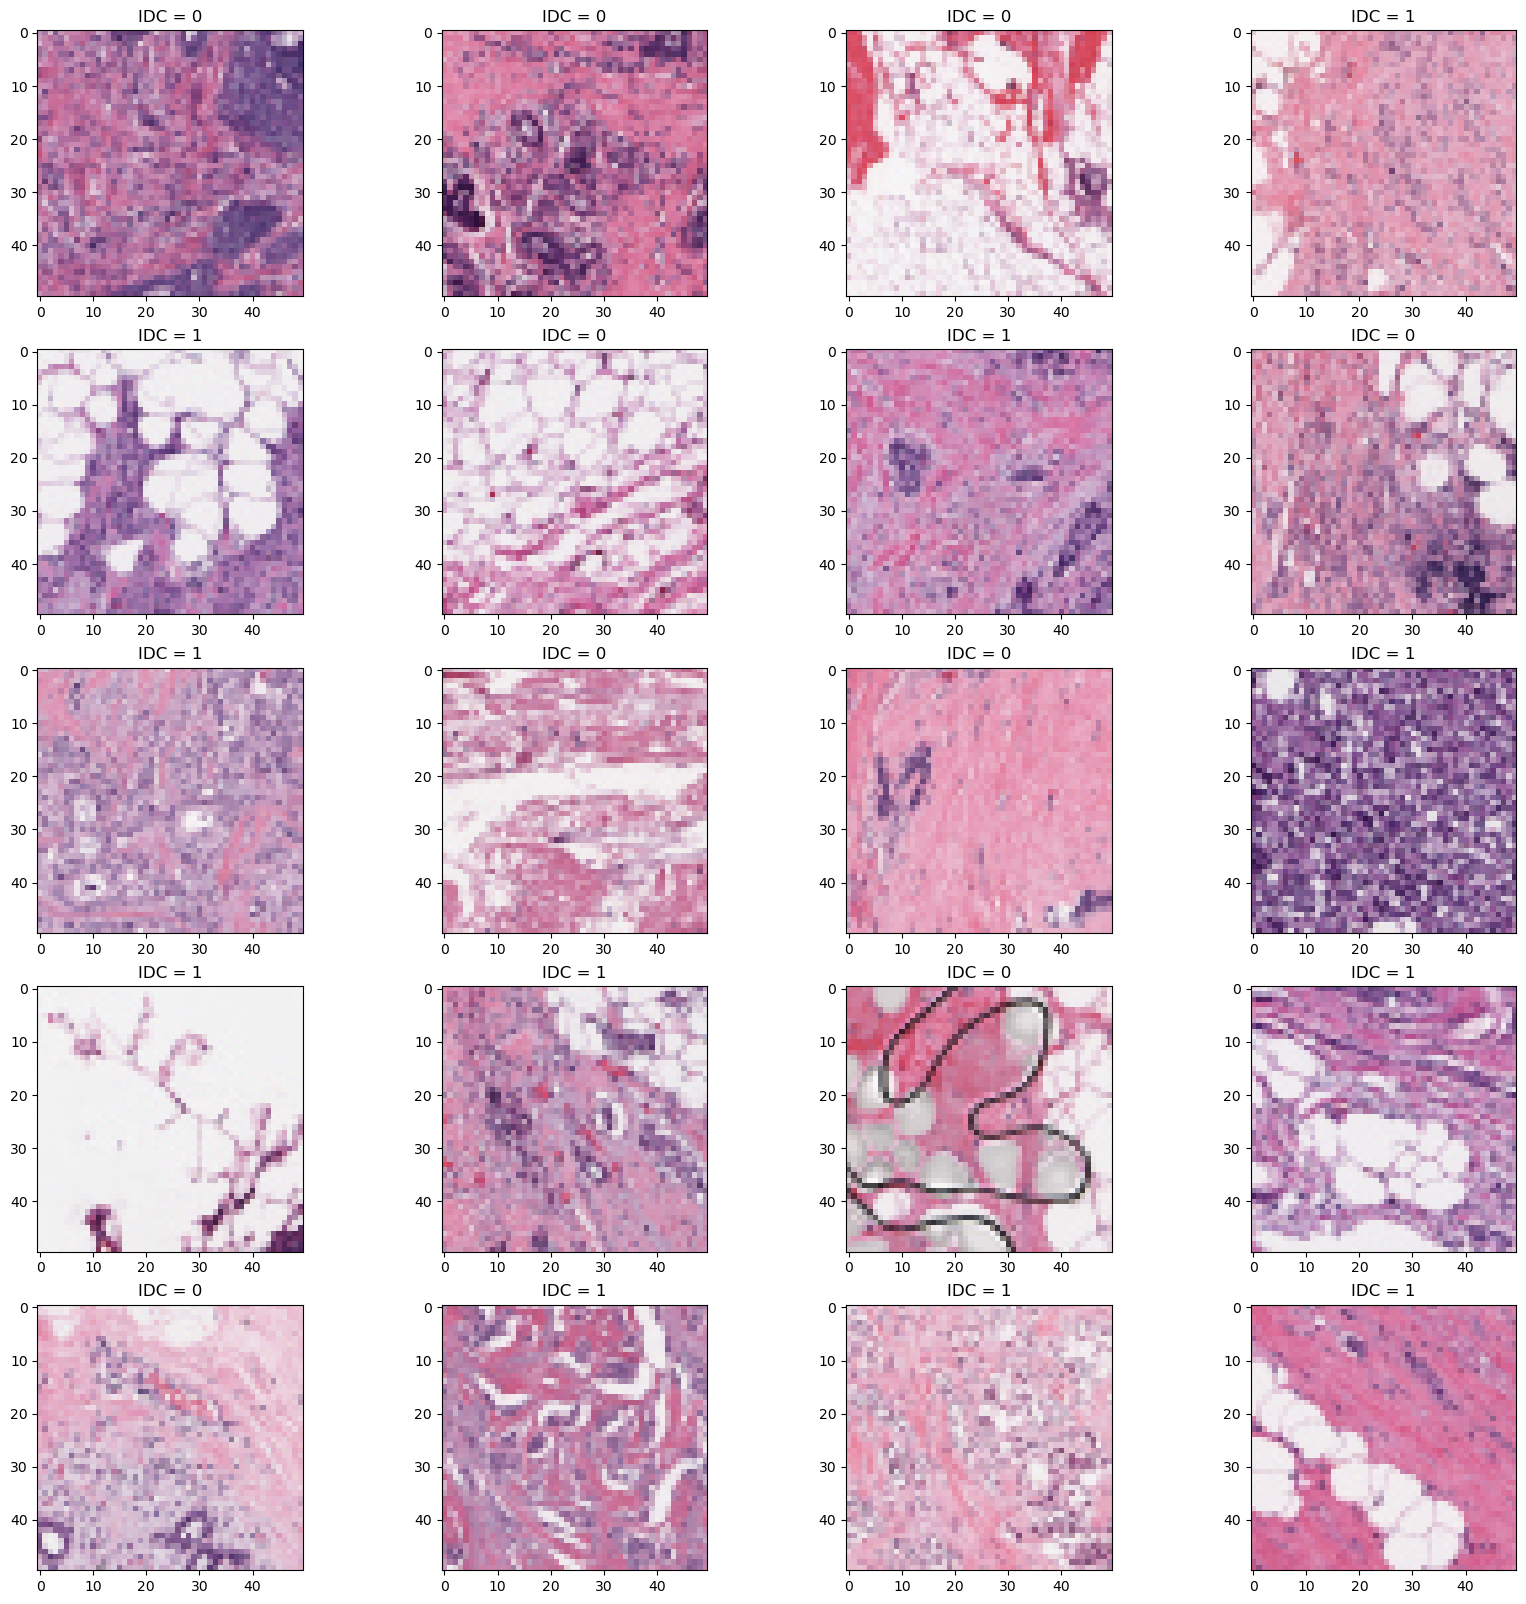

In [7]:
imgs_0 = X[Y == 0] # 0 = no IDC
imgs_1 = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

No difference at all to the normal eye

### View image data shape size, number of channels; minimum, average, standard deviation, maximum values of statistical data.

In [8]:
print('X_images.shape =', X.shape)
print('X_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X.min(),
                        X.mean(), X.std(), X.max()))

print('Y_images.shape =', Y.shape)#flag

X_images.shape = (5547, 50, 50, 3)
X_images.min/mean/std/max = 2.00/185.03/47.25/255.00
Y_images.shape = (5547,)


In [9]:
def describeData(a,b):
    # Total number of data images
    print('Total number of images: {}'.format(len(a))) 
    # Number of images with IDC of 0
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0))) 
    # Number of images with IDC of 1
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1))) 
    # Statistics on the percentage of images with an IDC of 1
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b))) 
    # Length, width and number of channels of the data sample
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape)) 
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


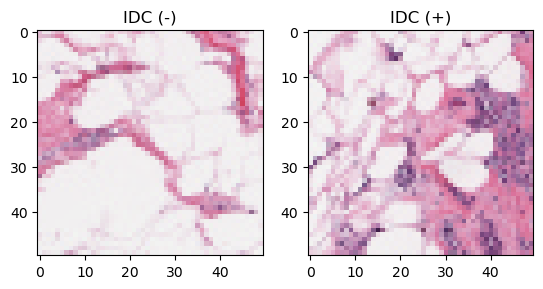

In [10]:
def plotOne(a,b):
    
    # The first image is drawn without lesions
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    
    # The second image is drawn with the lesion
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
    
plotOne(imgs_0, imgs_1) 

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size=0.2)
X_train = X_train[0:30000]  
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(X_test.shape)

(4437, 50, 50, 3)
(4437,)
(1110, 50, 50, 3)
(1110, 50, 50, 3)


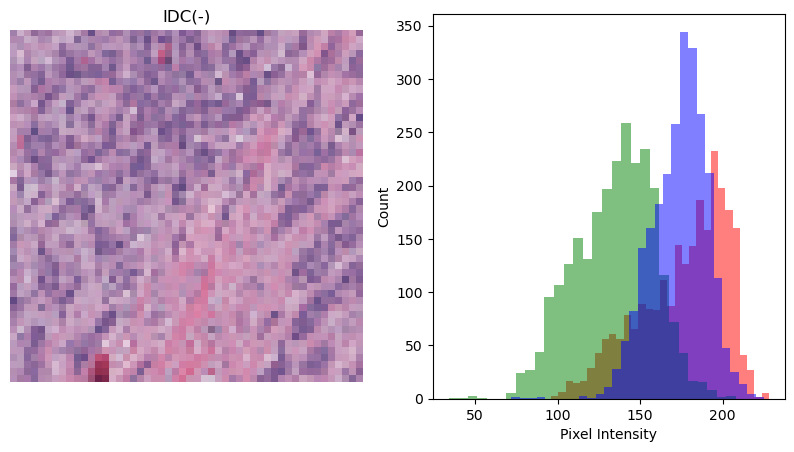

In [12]:
def plotHistogram(a):

    plt.figure(figsize=(10,5))
    
    # The first picture draws the selected image
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    
    # The second graph plots the three-channel histogram corresponding to the selected image
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count') # set y 
    histo.set_xlabel('Pixel Intensity') # set x 
    n_bins = 30
    
    # Plotting bar charts
    
    # R
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    # G
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5); 
    # B
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5); 
    
plotHistogram(X_train[30])

In [13]:
X_train = X_train / 256
X_test = X_test / 256
print("Training Data Shape:", X_train.shape, Y_train.shape) 
print("Testing Data Shape:", X_test.shape, Y_test.shape)

Training Data Shape: (4437, 50, 50, 3) (4437,)
Testing Data Shape: (1110, 50, 50, 3) (1110,)


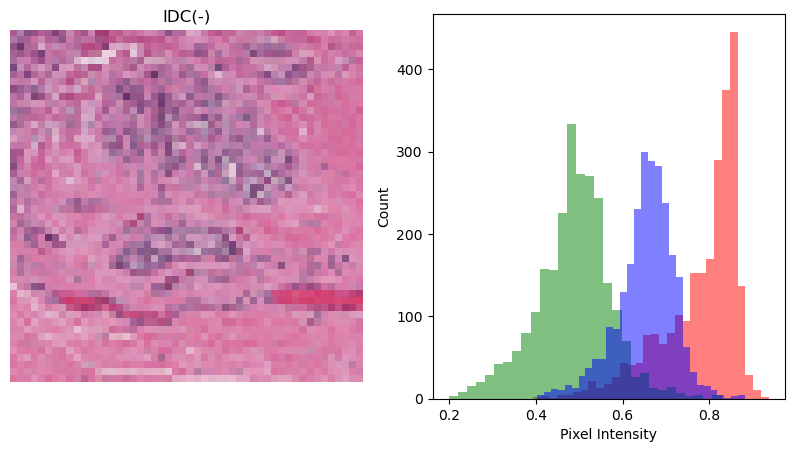

In [14]:
plotHistogram(X_train[111])

In [15]:
Y_train = to_categorical(Y_train, num_classes = 2) 
Y_test = to_categorical(Y_test, num_classes = 2)

The to_categorical function is used to convert a class vector (integers) to binary class matrix. It's commonly used in multi-class classification problems.I wasn't actually sure if this step was necessary in the dichotomous problem or not, as some papers and sources I read indicated that it didn't have a big impact, but I added it anyway to improve accuracy.

In [16]:
Y_train,Y_test#label set

(array([[0., 1.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32),
 array([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32))

In [17]:
# Defining callback functions
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [18]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [19]:
# Define confusion matrix auxiliary functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # draw cm
    plt.title(title)                                    # Set title
    plt.colorbar()                                      # Add colour bar
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=90)        # Setting the x-axis
    plt.yticks(tick_marks, classes)                     # Setting the y-axis
    
    # cm normalize
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        # Add a text message
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()            # Automatic repositioning of subplots
    plt.ylabel('True label')      # Set y-axis title
    plt.xlabel('Predicted label') # Set x-axis title

In [20]:
# Defining the learning curve function for keras
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()] # lodaing logs.npy
    filt = ['acc'] 
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        
        # Draw I, where the colour is red when val is in k and the label is val，
        # Otherwise set the colour to green and the label to train
        plt.plot(l, c= 'r' if 'val' not in k else 'b', 
                 label='val' if 'val' in k else 'train')
        
        # Determine the function and select the minimum index if the loss is in k, otherwise select the maximum index
        x = np.argmin(l) if 'loss' in k else np.argmax(l) 
        y = l[x]
        
        # Plotting scatter plots
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, 
                    c='r' if 'val' not in k else 'b') 
        
        # Add a text message 
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', 
                 color= 'r' if 'val' not in k else 'b')  
        
    plt.legend(loc=4) # Setup legend
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

# building the first neural network model 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 128)               4333696   
                                                        

INFO:tensorflow:Assets written to: ./model/model-1\assets


INFO:tensorflow:Assets written to: ./model/model-1\assets


model saved
Epoch 1/12
35/35 [==============================] - 12s 338ms/step - loss: 0.7074 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.4937
Epoch 2/12
35/35 [==============================] - 12s 334ms/step - loss: 0.7071 - accuracy: 0.4992 - val_loss: 0.6899 - val_accuracy: 0.4955
Epoch 3/12
35/35 [==============================] - 12s 332ms/step - loss: 0.7038 - accuracy: 0.4988 - val_loss: 0.6878 - val_accuracy: 0.4955
Epoch 4/12
35/35 [==============================] - 12s 331ms/step - loss: 0.6983 - accuracy: 0.5177 - val_loss: 0.6859 - val_accuracy: 0.4973
Epoch 5/12
35/35 [==============================] - 12s 330ms/step - loss: 0.6945 - accuracy: 0.5184 - val_loss: 0.6835 - val_accuracy: 0.5234
Epoch 6/12
35/35 [==============================] - 12s 331ms/step - loss: 0.6979 - accuracy: 0.5107 - val_loss: 0.6823 - val_accuracy: 0.5117
Epoch 7/12
35/35 [==============================] - 12s 331ms/step - loss: 0.6947 - accuracy: 0.5109 - val_loss: 0.6799 - val_accu

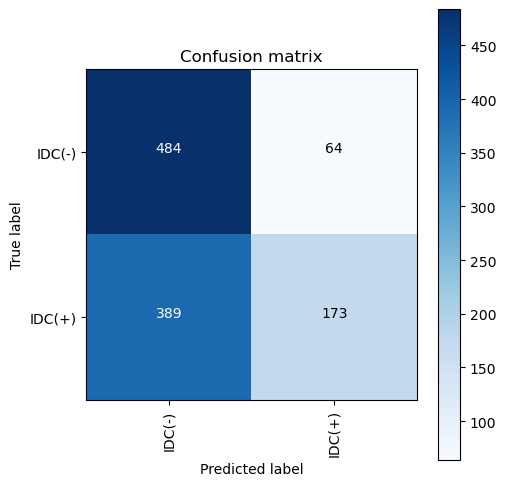

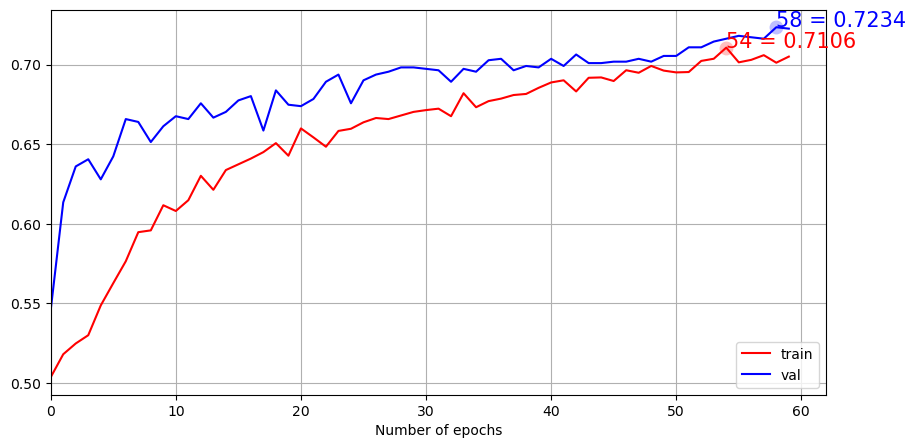

In [21]:
def runKerasCNN(a,b,c,d):
    batch_size = 128 # Size of each input data
    num_classes = 2  # Number of categories of classification(IDC=0,IDC=1)
    epochs = 12      # epochs
    img_rows, img_cols = X_train.shape[1],X_train.shape[2] # Length and width of sample data
    input_shape = (img_rows, img_cols, 3) # Converting it to the input format of a neural network
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    
    model = Sequential()
    
    # Adding convolutional layers
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    # Adding convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    # MaxPooling
    model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling
    model.add(Dropout(0.25))                  # Preventing over-fitting
    model.add(Flatten())                      # One-dimensionalising multidimensional input
    model.add(Dense(128, activation='relu'))  # Fully connected layer with activation function relu
    model.add(Dropout(0.5))                   # Preventing over-fitting
    
    # Output layer with two output classes and an activation function of softmax,
     #In fact, I think this kind of binary problem should also work with Sigmod
    model.add(Dense(num_classes, activation='softmax')) 
    
    # Compilation model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    #Show the model structure
    model.summary()
    
    # Put all content in TensorFlow SavedModel format
    model.save('./model/model-1')
    print('model saved')
    
    # Model training
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [tf_callback])#'logs'MetricsCheckpoint('logs')
    
    # The model assessment yields an assessment score
    score = model.evaluate(x_test, y_test, verbose=0) 
    print('\nKeras CNN #1A - accuracy:', score[1],'\n')
    
    # Model prediction
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    # Use classification_report to display a text report of the main classification indicators
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], 
                                                      np.argmax(y_pred, axis=1), 
                                                      target_names=list(map_characters.values())), 
          sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) # Predictive
    Y_true = np.argmax(Y_test,axis = 1)         # true
    
    # confusion_matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    
    #  plot_confusion_matrix
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 

runKerasCNN(X_train, Y_train,  X_test, Y_test) # Calling the model training function
plotKerasLearningCurve() # Mapping the learning curve

There is something wrong with the picture, it is of the next model

The confusion matrix indicates that the model will always predict IDC(+) as IDC(-), and the learning curve can be seen to perform poorly on both the training and validation sets. These results indicate that the model is still somewhat biased.

![Alt text](./img/model-1.h5.png)

In [22]:
%load_ext tensorboard

In [23]:
%tensorboard --logdir logs

# Building more powerful CNN networks

In [24]:
from keras.optimizers import Adam #Change the optimizer
#Not effective No need

In [25]:
def runKerasCNNAugment(a,b,c,d):

    batch_size = 128  
    num_classes = 2  
    epochs = 60      
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3) # batchsize
    x_train = a
    y_train = b
    x_test = c
    y_test = d
    model = Sequential()
    
    # C layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    # C layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))           #
    model.add(Dropout(0.25))                           
    model.add(Flatten())                                
    model.add(Dense(128, activation='relu'))            
    model.add(Dropout(0.5))                             
    model.add(Dense(num_classes, activation='softmax')) 
    model.summary()    
    
    
    
    model.save('./model/mode-2')
    print('model saved')    
    checkpoint = ModelCheckpoint(model.save)
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    # Data Augmentation！！！！！！！！！！！！！！！！！added
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,       # With an immediate rotation angle range of 10 degrees
        width_shift_range=0.1,   # Randomly shifting images horizontally
        height_shift_range=0.1,  # Vertical random shift image
        horizontal_flip=True,  
        vertical_flip=False)
    
    # Model training
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, 
                        epochs=epochs, 
                        validation_data = (c, d),
                        callbacks =[MetricsCheckpoint('logs')] )
    
    # Model evaluation
    score = model.evaluate(c,d, verbose=0) 
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    
    # predict
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], 
                                                      np.argmax(y_pred, axis=1), 
                                                      target_names=list(map_characters.values())), 
          sep='')    
    
    # 模model.evaluate
    score = model.evaluate(x_test, y_test, verbose=0) 
    Y_pred_classes = np.argmax(y_pred,axis = 1)              
    Y_true = np.argmax(Y_test,axis = 1)                      
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    
    # Drawing confusion matrices
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    

runKerasCNNAugment(X_train, Y_train,  X_test, Y_test) 
plotKerasLearningCurve() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4333696   
                                                      

KeyboardInterrupt: 

The model should be very good now, after more refined tuning. The learning curves show that the different shapes of the training and cross-validation curves do not overfit much, and both the confusion matrix and the learning curves indicate that the model is not highly biased.

However, unlike complex models such as RESNET, this model is in fact very simple with only two convolutional layers.

But DENSE is simpler and more brutal

![Alt text](./img/model-6.h5.png)